In [1]:
from transformers import CLIPProcessor, CLIPModel
import pandas as pd
from PIL import Image
import os
import torch
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dropout, BatchNormalization

import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt


c:\Users\nickb\anaconda3\envs\csc-752-final-project\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\nickb\anaconda3\envs\csc-752-final-project\lib\site-packages\transformers\utils\generic.py:260: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(


In [2]:
#file_path = "C:\\Users\\alan\\Medical Image Project\\combine_data\\BrEaST-Lesions-USG-clinical-data-Dec-15-2023.xlsx"
file_path = "BrEaST-Lesions-USG-clinical-data-Dec-15-2023.xlsx"
text_data = pd.read_excel(file_path)

In [3]:
text_data.shape

(256, 21)

In [4]:

# filter out normal rows
filtered_text_data = text_data[(text_data['Classification'] == 'benign') | (text_data['Classification'] == 'malignant')]

# Remove rows where Age is 'not available'
filtered_text_data = filtered_text_data[filtered_text_data['Age'] != 'not available']

# combine the relevant columns into a single text field per case
text_columns = [col for col in filtered_text_data.columns if col not in ['Image_filename', 'Classification', "Mask_tumor_filename","Mask_other_filename", "Pixel_size", "Verification","BIRADS"]]
filtered_text_data['combined_text'] = filtered_text_data[text_columns].apply(lambda x: ' '.join(x.dropna().astype(str)), axis=1)

# Show preview of data
filtered_text_data.head(10)

,CaseID,Image_filename,Mask_tumor_filename,Mask_other_filename,Pixel_size,Age,Tissue_composition,Signs,Symptoms,Shape,...,Posterior_features,Halo,Calcifications,Skin_thickening,Interpretation,BIRADS,Verification,Diagnosis,Classification,combined_text
0,1,case001.png,case001_tumor.png,NaN,0.007812,57,heterogeneous: predominantly fat,breast scar,family history of breast/ovarian cancer,irregular,...,shadowing,no,no,yes,Breast scar (surgery)&Breast scar (radiotherapy),2,confirmed by follow-up care,not applicable,benign,1 57 heterogeneous: predominantly fat breast s...
2,3,case003.png,case003_tumor.png,NaN,0.006944,56,heterogeneous: predominantly fat,no,nipple discharge,oval,...,no,no,no,no,Duct filled with thick fluid&Intraductal papil...,4a,confirmed by biopsy,Usual ductal hyperplasia (UDH)&Pseudoangiomato...,benign,3 56 heterogeneous: predominantly fat no nippl...
3,4,case004.png,case004_tumor.png,NaN,0.007812,43,homogeneous: fibroglandular,no,no,round,...,no,no,no,no,Cyst filled with thick fluid,3,confirmed by follow-up care,not applicable,benign,4 43 homogeneous: fibroglandular no no round c...
4,5,case005.png,case005_tumor.png,NaN,0.007812,67,homogeneous: fat,nipple retraction&palpable,family history of breast/ovarian cancer,oval,...,enhancement,no,no,no,Suspicion of malignancy&Intraductal papilloma,4b,confirmed by biopsy,Encapsulated papillary carcinoma&Ductal carcin...,malignant,5 67 homogeneous: fat nipple retraction&palpab...
5,6,case006.png,case006_tumor.png,NaN,0.007812,56,heterogeneous: predominantly fat,no,HRT/hormonal contraception,irregular,...,no,no,intraductal,no,Suspicion of malignancy&Intraductal papilloma&...,4b,confirmed by biopsy,Fibrosclerosis,benign,6 56 heterogeneous: predominantly fat no HRT/h...
6,7,case007.png,case007_tumor.png,NaN,0.007812,52,heterogeneous: predominantly fat,palpable,not available,irregular,...,shadowing,no,no,no,Suspicion of malignancy,5,confirmed by biopsy,Invasive carcinoma of no special type (NST),malignant,7 52 heterogeneous: predominantly fat palpable...
8,9,case009.png,case009_tumor.png,NaN,0.010355,76,heterogeneous: predominantly fibroglandular,no,not available,irregular,...,no,no,no,no,Suspicion of malignancy&Dysplasia,4b,confirmed by biopsy,Fibrosclerosis,benign,9 76 heterogeneous: predominantly fibroglandul...
9,10,case010.png,case010_tumor.png,NaN,0.010780,34,not available,not available,not available,irregular,...,enhancement,yes,no,no,Suspicion of malignancy&Dysplasia&Fibroadenoma...,4c,confirmed by biopsy,Invasive carcinoma of no special type (NST)&Du...,malignant,10 34 not available not available not availabl...
10,11,case011.png,case011_tumor.png,NaN,0.008681,70,heterogeneous: predominantly fibroglandular,palpable,family history of breast/ovarian cancer,irregular,...,shadowing,no,no,no,Suspicion of malignancy,4c,confirmed by biopsy,Invasive carcinoma of no special type (NST),malignant,11 70 heterogeneous: predominantly fibroglandu...
11,12,case012.png,case012_tumor.png,NaN,0.010780,74,not available,not available,not available,irregular,...,enhancement,yes,no,no,Suspicion of malignancy&Fibroadenoma&Intraduct...,5,confirmed by biopsy,Invasive carcinoma of no special type (NST)&In...,malignant,12 74 not available not available not availabl...


In [5]:
model_name = "openai/clip-vit-base-patch32"
processor = CLIPProcessor.from_pretrained(model_name)
model = CLIPModel.from_pretrained(model_name)

text_inputs = processor(text=filtered_text_data["combined_text"].tolist(), padding=True, truncation=True, return_tensors="pt")


c:\Users\nickb\anaconda3\envs\csc-752-final-project\lib\site-packages\huggingface_hub\file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
c:\Users\nickb\anaconda3\envs\csc-752-final-project\lib\site-packages\transformers\modeling_utils.py:479: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless the

In [6]:
text_embeddings = model.get_text_features(**text_inputs)

In [7]:
text_embeddings.shape

torch.Size([211, 512])

In [8]:
# image feature extraction
def get_image_embedding(image_path, processor, model):
    # Load and process the image
    image = Image.open(image_path).convert("RGB")
    inputs = processor(images=image, return_tensors="pt")
    
    # Generate embedding
    with torch.no_grad():  # Ensure no gradients are calculated
        image_embedding = model.get_image_features(**inputs)
    
    return image_embedding


In [9]:
# Initialize an empty list to hold image embeddings
image_embeddings = []

# Base path for images
base_path = "BrEaST-Lesions_USG-images_and_masks/"

# Loop through each row in the DataFrame
for filename in filtered_text_data['Image_filename']:
    image_path = os.path.join(base_path, filename)
    embedding = get_image_embedding(image_path, processor, model)
    image_embeddings.append(embedding)

# Convert the list of embeddings into a tensor (or any format you prefer)
image_embeddings_tensor = torch.stack(image_embeddings)


In [10]:
# convert both embedding into same demision
image_embeddings_tensor = image_embeddings_tensor.squeeze(-1)  # Squeeze the last dimension if it's extraneous

image_embeddings_tensor = image_embeddings_tensor.view(image_embeddings_tensor.shape[0], -1)  # Flatten to [number_of_samples, image_feature_size * some_other_dimension]

# Now try concatenating again
combined_embeddings = torch.cat((text_embeddings, image_embeddings_tensor), dim=1)
print(text_embeddings.shape)
print(image_embeddings_tensor.shape)

torch.Size([211, 512])
torch.Size([211, 512])


In [11]:

print(combined_embeddings.shape)

torch.Size([211, 1024])


In [12]:
# add label
labels = filtered_text_data['Classification'].values
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)  # Converts labels to numerical format


In [13]:
encoded_labels

array([0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0,
       1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1,
       0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1,
       1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1,
       1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0,
       0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1,
       1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0])

In [14]:
# split the data

# Convert it to a NumPy array
X = combined_embeddings.detach().numpy()

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, encoded_labels, test_size=0.2, random_state=42)

model = Sequential([
    Dense(128, activation='relu', input_dim=X_train.shape[1]),
    Dropout(0.2),                 # Dropout layer for regularization
    Dense(64, activation='relu'),
    BatchNormalization(),         # BatchNormalization layer for normalization
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model with validation data
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.4, verbose=1)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)

print(f"Test Loss: {test_loss}\nTest Accuracy: {test_accuracy}")

Epoch 1/10
4/4 [==============================] - 1s 96ms/step - loss: 0.7996 - accuracy: 0.5100 - val_loss: 0.7032 - val_accuracy: 0.3824
Epoch 2/10
4/4 [==============================] - 0s 11ms/step - loss: 0.6224 - accuracy: 0.6500 - val_loss: 0.6060 - val_accuracy: 0.6176
Epoch 3/10
4/4 [==============================] - 0s 10ms/step - loss: 0.5481 - accuracy: 0.7200 - val_loss: 0.5715 - val_accuracy: 0.7500
Epoch 4/10
4/4 [==============================] - 0s 11ms/step - loss: 0.4679 - accuracy: 0.8000 - val_loss: 0.5270 - val_accuracy: 0.8529
Epoch 5/10
4/4 [==============================] - 0s 11ms/step - loss: 0.4701 - accuracy: 0.7900 - val_loss: 0.4769 - val_accuracy: 0.8824
Epoch 6/10
4/4 [==============================] - 0s 12ms/step - loss: 0.3510 - accuracy: 0.8900 - val_loss: 0.4315 - val_accuracy: 0.9559
Epoch 7/10
4/4 [==============================] - 0s 12ms/step - loss: 0.3334 - accuracy: 0.8700 - val_loss: 0.4047 - val_accuracy: 0.9706
Epoch 8/10
4/4 [===========

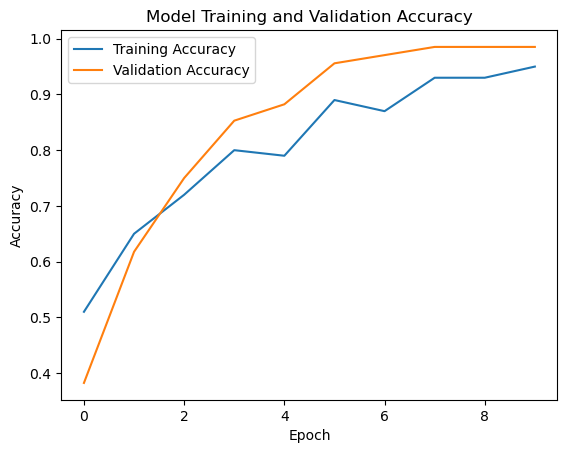

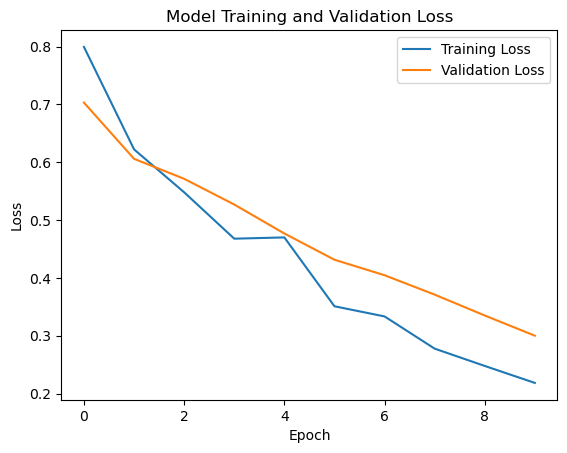

In [15]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Training and Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [16]:
con_mat = confusion_matrix(y_test, np.squeeze(model.predict(X_test)>0.5))
print(con_mat)

2/2 [==============================] - 0s 2ms/step
[[17  1]
 [ 1 24]]


In [17]:
tn, fn, fp, tp = con_mat[0,0], con_mat[0,1], con_mat[1,0], con_mat[1,1]
precision = tp/(tp+fp)
recall = tp/(tp+fn)
f1 = 2 * (precision * recall)/(precision + recall)
print(precision, recall, f1)

0.96 0.96 0.96


In [18]:
confusion_matrix([1,1,1],[1,0,1])

array([[0, 0],
       [1, 2]], dtype=int64)